In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from mixmil.paths import DATA
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import anndata as ad
from mixmil import MixMIL
import torch
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import scipy.stats as st

In [3]:
dataset_index_file = DATA / "camelyon16" / "Camelyon16.csv"
bagdf = pd.read_csv(dataset_index_file)
bagdf.columns = ["file", "label"]
bagdf["file"] = bagdf["file"].str.replace("datasets/Camelyon16/", "")
bagdf["split"] = bagdf["file"].apply(lambda x: "test" if "test" in x else "train")
bagdf = bagdf.set_index("file")
bagdf

,label,split
file,,
1-tumor/test_033.csv,1,test
0-normal/normal_148.csv,0,train
0-normal/test_095.csv,0,test
0-normal/normal_025.csv,0,train
0-normal/test_087.csv,0,test
...,...,...
0-normal/normal_006.csv,0,train
1-tumor/tumor_003.csv,1,train
0-normal/normal_018.csv,0,train


In [4]:
dtype = "float32"
n_pcs = 128

if not (DATA / "camelyon16" / "test.h5ad").exists() or not (DATA / "camelyon16" / "train.h5ad").exists():
    train_data = []
    train_bag_indices = []
    for _, row in tqdm(list(bagdf[bagdf["split"] == "train"].iterrows())):
        train_data.append(pd.read_csv(dataset_index_file.parent / row.name).values.astype(dtype))
        train_bag_indices.extend([row.name] * len(train_data[-1]))

    test_data = []
    test_bag_indices = []
    for _, row in tqdm(list(bagdf[bagdf["split"] == "test"].iterrows())):
        test_data.append(pd.read_csv(dataset_index_file.parent / row.name).values.astype(dtype))
        test_bag_indices.extend([row.name] * len(test_data[-1]))

    i_train = np.array([idx for idx, x in enumerate(train_data) for _ in range(len(x))])
    X_train = np.concatenate(train_data, 0).astype(dtype)
    X_test = np.concatenate(test_data, 0).astype(dtype)
    pca = PCA(n_components=n_pcs)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(pca.fit_transform(X_train))
    X_test = scaler.transform(pca.transform(X_test))

    train_obs = pd.DataFrame(
        {"bag": train_bag_indices, "label": bagdf.loc[train_bag_indices]["label"].values, "split": "train"}
    )
    train_adata = ad.AnnData(X_train, obs=train_obs, var=pd.DataFrame(index=[f"PC{i}" for i in range(n_pcs)]))
    test_obs = pd.DataFrame(
        {"bag": test_bag_indices, "label": bagdf.loc[test_bag_indices]["label"].values, "split": "test"}
    )
    test_adata = ad.AnnData(X_test, obs=test_obs, var=pd.DataFrame(index=[f"PC{i}" for i in range(n_pcs)]))

    test_adata.write(DATA / "camelyon16"  / "test.h5ad")
    train_adata.write(DATA / "camelyon16"  / "train.h5ad")
else:
    print("Loading precomputed anndatas")
    train_adata = ad.read_h5ad(DATA / "camelyon16" / "train.h5ad")
    test_adata = ad.read_h5ad(DATA / "camelyon16" / "test.h5ad")

Loading precomputed anndatas


In [5]:
train_bags = train_adata.obs["bag"].unique().tolist()
Xs = [torch.Tensor(train_adata[train_adata.obs["bag"] == bag].X) for bag in train_bags]
F = torch.ones((len(train_bags), 1))
Y = torch.Tensor(train_adata.obs[["bag", "label"]].drop_duplicates().set_index("bag").loc[train_bags].values)

In [6]:
test_bags = test_adata.obs["bag"].unique().tolist()
test_Xs = [torch.Tensor(test_adata[test_adata.obs["bag"] == bag].X) for bag in test_bags]
test_Y = torch.Tensor(test_adata.obs[["bag", "label"]].drop_duplicates().set_index("bag").loc[test_bags].values)

In [33]:
# model = MixMIL.init_with_mean_model(Xs, F, Y, likelihood="binomial", n_trials=1)
# y_pred = model.predict(test_Xs)
# print("Test AUC:", round(roc_auc_score(test_Y, y_pred), 3))

GLMM Init:   0%|          | 0/1 [00:00<?, ?it/s]

Test AUC: 0.706


In [76]:
model = MixMIL.init_with_mean_model(Xs, F, Y, likelihood="binomial", n_trials=2)
y_pred_mean = model.predict(test_Xs)
print("Test AUC:", round(roc_auc_score(test_Y, y_pred_mean), 3), "Spearman:", round(st.spearmanr(test_Y, y_pred_mean).correlation, 3))


GLMM Init:   0%|          | 0/1 [00:00<?, ?it/s]

Test AUC: 0.694 Spearman: 0.326


In [77]:
hist = model.train(Xs, F, Y, n_epochs=50)
hdf = pd.DataFrame(hist)
y_pred = model.predict(test_Xs)
print("Test AUC:", round(roc_auc_score(test_Y, y_pred), 3), "Spearman:", round(st.spearmanr(test_Y, y_pred).correlation, 3))

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Test AUC: 0.94 Spearman: 0.739


Text(0.5, 1.0, 'Loss')

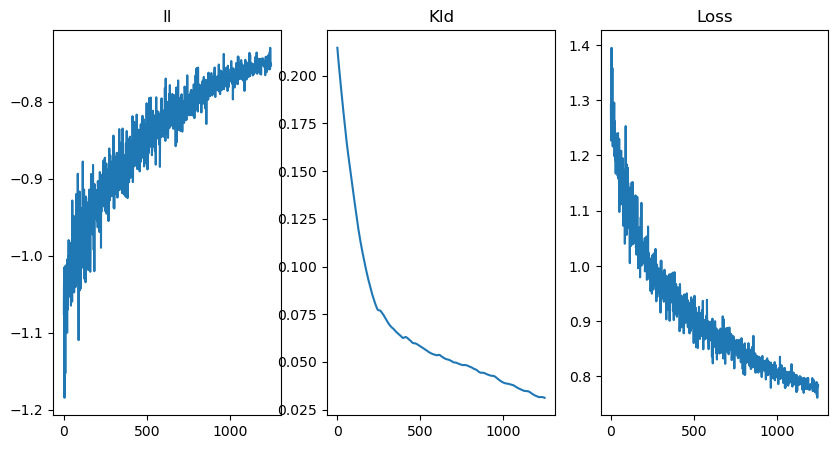

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].plot(hdf["ll"])
axes[0].set_title("ll")
axes[1].plot(hdf["kld"])
axes[1].set_title("Kld")
axes[2].plot(hdf["loss"])
axes[2].set_title("Loss")



Text(0.5, 1.0, 'Loss')

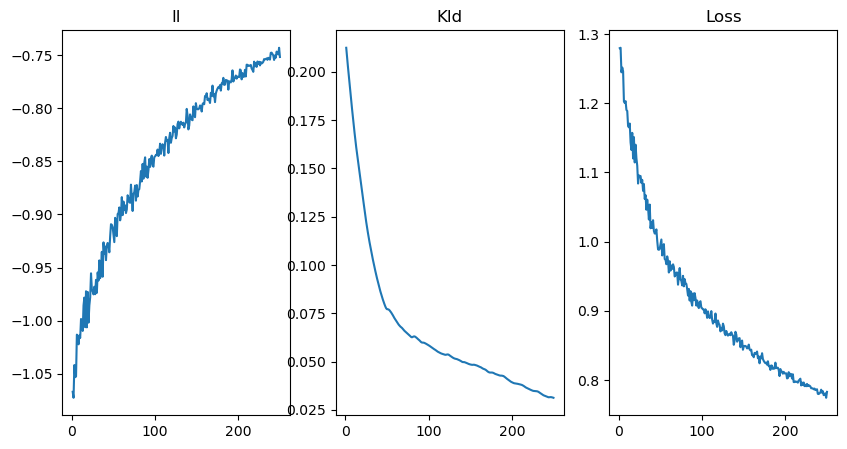

In [64]:
mhdf = hdf.groupby("epoch").mean()
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].plot(mhdf["ll"])
axes[0].set_title("ll")
axes[1].plot(mhdf["kld"])
axes[1].set_title("Kld")
axes[2].plot(mhdf["loss"])
axes[2].set_title("Loss")

